# CS 480/680 assignment 2

Tips:
- Please save a copy of this notebook to avoid losing your changes.
- Debug your code and ensure that it can run.
- Save the output of each cell. Failure to do so may result in your coding questions not being graded.
- To accelerate the training time, you can choose 'Runtime' -> 'Change runtime type' -> 'Hardware accelerator' and set 'Hardware accelerator' to 'GPU'. I tested the code on different devices: A100, T4, and M1 CPU; the execution times for training are approximately 14 minutes, 15 minutes, and 41 minutes, respectively.
- Your grade is independent of the test accuracy (unless it is 10%, as 10% is the accuracy of random guess).

Tips for sumbission:
- Do not change the order of the problems.
- Select 'Runtime' -> 'Run all' to run all cells and generate a final "gradable" version of your notebook and save your ipynb file.
- Also use 'File' -> 'Print' and then print your report from your browser into a PDF file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.optim import Optimizer
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from typing import Tuple
from math import floor, sqrt
import random as rand

## Helper functions

You can use the following functions to verify the correctness of your implementation. For example, you can call ```verify_conv2d()``` to check the effectiveness of your ```Conv2d``` implementation.

In [2]:
def verify_conv2d():
    x = torch.randn(2, 4, 64, 64)
    in_channels = 4
    out_channels = 16
    kernel_size = 3
    stride = 3
    padding = 2


    conv_pytorch = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    output_pytorch = conv_pytorch(x)

    conv_custom = Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    conv_custom.weight.data = conv_pytorch.weight.data.clone()
    conv_custom.bias.data = conv_pytorch.bias.data.clone()
    output_custom = conv_custom(x)
    difference = (output_pytorch - output_custom).abs().max()
    return (difference < 1e-06).item()

In [3]:
@torch.no_grad
def verify_dropout():
    p = rand.random()
    n = int(1e5)
    x = torch.randn(5,)
    x = x.to(device)

    weight = torch.randn(5,)
    weight = weight.to(device)

    y = torch.dot(x, weight)
    y = y.to(device)

    print('x dot product weight', y)

    dropout_pytorch = nn.Dropout(p)
    dropout_custom = Dropout(p)

    dropout_pytorch.eval()
    dropout_custom.eval()

    output_pytorch = torch.dot(weight, dropout_pytorch(x))
    output_custom = torch.dot(weight, dropout_custom(x))
    assert torch.allclose(output_pytorch, output_custom), "The outputs are not the same in evaluation mode."

    dropout_pytorch.train()
    dropout_custom.train()

    pytorch_dropout_train = torch.zeros_like(output_pytorch)
    custom_dropout_train = torch.zeros_like(output_custom)


    for _ in range(n):
        x_hat = dropout_pytorch(x)
        pytorch_dropout_train += torch.dot(x_hat, weight)
        x_hat = dropout_custom(x)
        custom_dropout_train += torch.dot(x_hat, weight)

    pytorch_dropout_train /= n
    custom_dropout_train /= n

    print('Empirical mean of Pytorch Dropout result', pytorch_dropout_train)
    print('Empirical mean of Custom Dropout result', custom_dropout_train)

In [4]:
@torch.no_grad
def verify_batchnorm():
    x = torch.randn(2, 3, 4, 4)

    num_features = x.shape[1]

    custom_bn = BatchNorm2d(num_features, eps=1e-5, momentum=0.1)
    pytorch_bn = nn.BatchNorm2d(num_features, eps=1e-5, momentum=0.1)

    pytorch_bn.weight.data = custom_bn.weight.data.clone()
    pytorch_bn.bias.data = custom_bn.bias.data.clone()
    pytorch_bn.running_mean = custom_bn.running_mean.clone()
    pytorch_bn.running_var = custom_bn.running_var.clone()

    custom_bn.train()
    pytorch_bn.train()

    output_custom = custom_bn(x)
    output_pytorch = pytorch_bn(x)

    difference = (output_custom - output_pytorch).abs().max()
    return (difference < 1e-06).item()

In [5]:
@torch.no_grad
def eval_accuracy(model, eval_loader, device):
    model.eval()
    n_correct = 0
    n_total = 0
    for imgs, labels in eval_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        _, pred = torch.max(logits, 1)

        n_correct += (pred == labels).sum().item()
        n_total += len(labels)

    return n_correct / n_total

In [6]:
def plot_curves(train_error_rates, val_error_rates):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_error_rates) + 1)
    plt.plot(epochs, train_error_rates, 'bo-', label='Training Error')
    plt.plot(epochs, val_error_rates, 'ro-', label='Validation Error')
    plt.title('Training and Validation Error Rates')
    plt.xlabel('Epochs')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def show_batch(data_loader):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    fig = plt.figure(figsize=(25, 4))
    for idx in range(20):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        ax.set_title(classes[labels[idx]])

# Question 1. Loading dataset (5 points)
In this question, you are asked to fill out the ```build_loaders```, in other words, to prepare the training, validation, and test sets. In the following code, you need to randomly split ```train_data``` into training and validation sets. We use 80% of ```train_data``` as the training set and the rest of ```train_data``` as the validation set. Please use DataLoader in PyTorch to create three different dataloaders: one each for training, validation, and testing.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(2024)

In [9]:
batch_size = 128

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    normalize,
])


train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
def build_loaders(train_data: torch.utils.data.Dataset,
                  test_data: torch.utils.data.Dataset,
                  train_ratio: float=0.8,
                  val_ratio: float=0.2,
                  batch_size:int=batch_size) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Args:
    - train_data: CIFAR-10 train data
    - test_data: CIFAR-10 test data
    - train_ratio: ratio of training
    - val_ratio: ratio of validation
    - batch_size: Batch size
    Returns:
    - train_loader: Dataloader for training
    - val_loader: Dataloader for validation
    - test_loader: Dataloader for test
    """
    # TODO: Random split CIFAR-10 train-validation sets
    [train_split, valid_split] = torch.utils.data.random_split(train_data, [train_ratio, val_ratio])


    # TODO: Return train/val/test loaders
    return DataLoader(train_split, batch_size, shuffle=True), DataLoader(valid_split, batch_size, shuffle=True), DataLoader(test_data, batch_size, shuffle=True)


In [11]:
train_loader, val_loader, test_loader = build_loaders(train_data, test_data)

### Visualize a Batch of Training Data

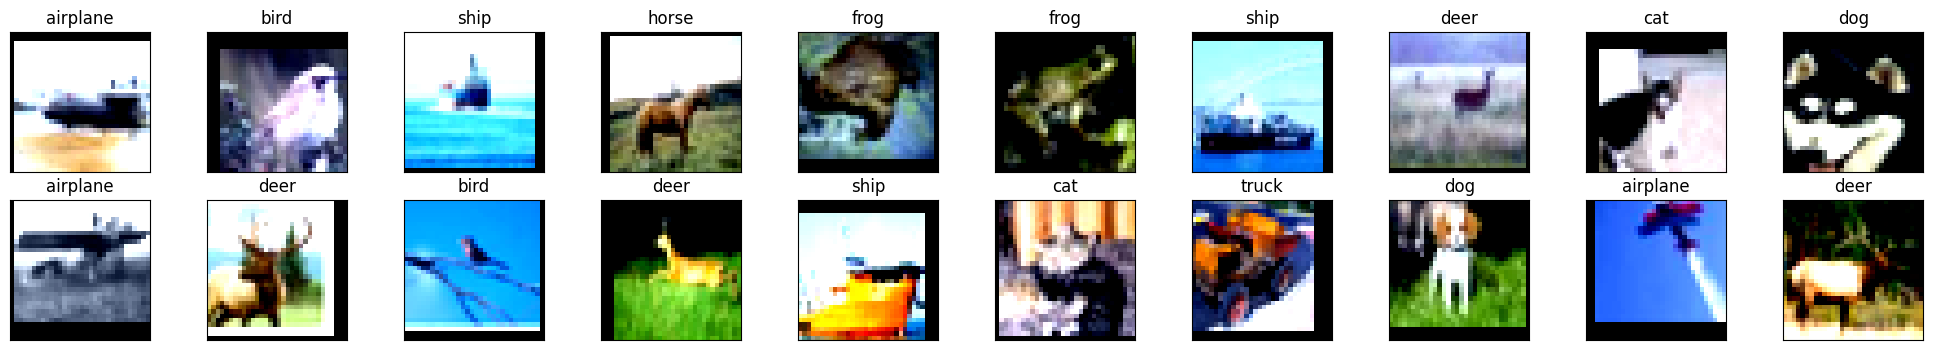

In [12]:
show_batch(train_loader)

# Question 2. Implementing Conv2d (20 points)
In this question, you are asked to implement a multi-channel convolution operator for 2D images, a.k.a., a 2D cross-correlation operator. If you directly use PyTorch's built-in conv2d class (e.g., ```torch.nn.Conv2d``` or ```torch.nn.functional.conv2d```), you will only receive one mark for this question. But, you're welcome to use Pytorch's built-in ```pad``` function. You can use ```verify_conv2d()``` to compare your Conv2d operator with PyTorch's built-in conv2d operator. Please fill out the ```forward``` function in ```Conv2d```.

In [13]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(Conv2d, self).__init__()

        assert in_channels > 0 and out_channels > 0 and kernel_size > 0
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.randn(out_channels))

    def forward(self, x):
        """
        Args:
        - x: input tensor
        Returns:
        - output: convoluted tensor
        """
        n, cin, hin, win = x.shape
        cout = self.weight.shape[0]
        cin = self.weight.shape[1]

        hout = floor((hin + 2*self.padding - self.kernel_size)/self.stride + 1)
        wout = floor((win + 2*self.padding - self.kernel_size)/self.stride + 1)

        res = torch.zeros(n, cout, hout, wout)
        for ni in range(n):
          for j in range(cout):
            # 2D cross-correlation operation
            for h in range(hout):
              for w in range(wout):
                for i in range(cin):
                  inputs = F.pad(x[ni, i, :, :], (self.padding, self.padding, self.padding, self.padding))
                  block = inputs[h*self.stride : h*self.stride + self.kernel_size, w*self.stride : w*self.stride + self.kernel_size]
                  res[ni , j, h, w] += torch.sum(self.weight[j, i] * block)
            # Bias
            res[ni, j, : , :] += self.bias[j]

        return res


In [14]:
conv2d_passed = verify_conv2d()
print('Passed conv2d test:', conv2d_passed)

Passed conv2d test: True


# Question 3. Dropout (20 points)
In this question, you are asked to implement a dropout layer. If you directly use PyTorch's built-in dropout class (e.g., ```torch.nn.Dropout``` or ```torch.nn.functional.dropout```), you will only receive one mark for this question.

## Question 3.1 Should We Rescale Our Dropout Output? (10 points)
Consider a simple scenario where there is an input vector $\mathbf{x}$ and a linear layer with weights $\mathbf{w}$ and zero bias. Before this linear layer, we add a dropout layer with dropout probability $p$. Should we rescale the output of the dropout layer? Please state your choice and explain your reasoning. If you choose to rescale the dropout output, what should the rescale factor be? (Tip: What is the ***unbiased*** estimator for the output during the training time?)

### Your answer for question 3.1: Yes we should rescale the output. Since the dropout layer is only present during the training phase, the output of the layer during inference phase would be larger as a percentage of neurons were deactivated during training. During training phase, the expected value is $(1-p)E[W^tx]$ since p is the probability a neuron is zeroed out. We should rescale the factor by $\frac{1}{1-p}$ to compensate.

## Question 3.2 Implement your Dropout Layer (10 points)
Based on the above question, you should implement your own scaled/unscaled dropout layer. You can use ```verify_dropout()``` to compare your dropout layer with PyTorch's built-in dropout layer. Please fill out the ```forward``` function in ```Dropout```.

In [15]:
class Dropout(nn.Module):
    def __init__(self, p):
        super(Dropout, self).__init__()
        """
        Args:
        - p: dropout rate
        """
        assert p >= 0 and p <= 1
        self.p = p

    def forward(self, x):
        """
        Args:
        - x: input tensor
        Returns:
        - output: dropout tensor
        """
        res = x.clone()

        if self.training:
          mask = torch.bernoulli(torch.full(x.shape, 1-self.p))
          mask = mask.to(device)
          res *= mask/(1-self.p)

        return res


In [16]:
verify_dropout()

x dot product weight tensor(-4.3127, device='cuda:0')
Empirical mean of Pytorch Dropout result tensor(-4.3177, device='cuda:0')
Empirical mean of Custom Dropout result tensor(-4.3117, device='cuda:0')


# Question 4. Implementing BatchNorm2d (15 points)
In this question, you are asked to implement BatchNorm2d for the training stage. If you directly use PyTorch's built-in batch normalization 2d class (e.g., ```torch.nn.BatchNorm2d``` or ```torch.nn.functional.batch_norm```), you will only receive one mark for this question. You can use ```verify_batchnorm()``` to compare your BatchNorm2d with PyTorch's built-in BatchNorm2d. Please fill out the ```forward``` function in ```BatchNoram2d``` for training.

### Tips:
During training. Given a batch $\mathcal{B} = \{\mathbf{x}^{(1)}, \dots, \mathbf{x}^{(m)}\}$ with size $m$. We use $\mathbf{x}^{(i)}$ to represent $j$-th channel in $i$-th sample. For each channel $j$, we need to compute
$\boldsymbol{\mu}_{j} = \frac{1}{m}\sum_{i=1}^{m} \mathbf{x}^{(i)}_j$ and
$\boldsymbol{\sigma}_{j}^2 = \frac{1}{m}\sum_{i=1}^m (\mathbf{x}^{(i)}_j - \boldsymbol{\mu}_j)^2.$ Then, there are learnable parameters $\gamma$ and $\beta$. $$BN(\mathbf{x}^{(i)}_j) = \gamma \frac{\mathbf{x}^{(i)}_j - \boldsymbol{\mu}_j}{\sqrt{\boldsymbol{\sigma}^2_j + \epsilon}} + \beta,$$
where $\epsilon$ is a hyperparameter for numerical stability. Again, the above equation is for each channel. If there are three channels, then there are three different $\gamma$s and $\beta$s for each channel.


In [17]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        self.weight = nn.Parameter(torch.ones(num_features))
        self.bias = nn.Parameter(torch.zeros(num_features))

        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

        self.reset_parameters()

    def reset_parameters(self):
        self.running_mean.zero_()
        self.running_var.fill_(1)
        nn.init.uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        if self.training:
            # TODO: BatchNorm2d in training.
            batch_mean = x.mean([0, 2, 3], keepdim=True)
            batch_var = x.var([0, 2, 3], keepdim=True, unbiased=False)

            # Update running statistics without in-place operations
            self.running_mean = (1 - self.momentum) * self.running_mean.detach() + self.momentum * batch_mean.detach().squeeze()
            self.running_var = (1 - self.momentum) * self.running_var.detach() + self.momentum * x.var([0, 2, 3], keepdim=True, unbiased=True).detach().squeeze()
            # Thanks for correction in Piazza.

            x = (x - batch_mean) / (batch_var + self.eps).sqrt()
            pass
        else:
            x = (x - self.running_mean.view(1, self.num_features, 1, 1)) / \
                (self.running_var.view(1, self.num_features, 1, 1) + self.eps).sqrt()

        x = x * self.weight.view(1, self.num_features, 1, 1) + self.bias.view(1, self.num_features, 1, 1)
        return x


In [18]:
passed = verify_batchnorm()
print('Customize BatchNormalization 2d passed: ', passed)

Customize BatchNormalization 2d passed:  True


# Question 5. Loss function and SGD (15 points)
In this question, you are asked to implement cross-entropy loss and SGD. If you directly use PyTorch build-in functions, e.g., ```torch.nn.functional.cross_entropy``` or ```torch.nn.CrossEntropyLoss``` or ```torch.optim.SGD```, you will only receive one mark for this question. But, you're welcom to use ```torch.nn.functional.softmax``` or ```torch.logsumexp```

## Question 5.1. Computing graident of Cross-Entropy Loss. (5 points)

Let $C$ be the number of classes. We define the cross-entropy loss as $L(\hat{y}, k) = -\sum_{i=1}^C y_i \log \hat{y}_i$, where $\hat{y}$ is the output probability, $k$ is the true label, and $y = \text{OneHot}(k)$. In practice, $\hat{y} = \text{softmax}(\mathbf{W}f(\mathbf{x}) + \mathbf{b})$, where $\mathbf{W} \in \mathbb{R}^{C \times d}$, $\mathbf{b} \in \mathbb{R}^C$, and $f(\mathbf{x}) \in \mathbb{R}^d$. In this question, you are asked to compute the partial derivatives: $\frac{\partial L}{\partial \mathbf{W}{ij}}$ and $\frac{\partial L}{\partial \mathbf{b}_i}$.

#### Your Answer for Question 5.1:

Let $z = W f(x) + b$.

We have $L = -\sum_{i=1}^C y_i \log \hat{y}_i$,

$\frac{\partial L}{\partial z_j} = -\sum_{i=1}^C y_i \frac{1}{\hat{y}_i}\frac{\partial \hat{y}_i}{\partial z_j}$

Consider $\frac{\partial \hat{y}_i}{\partial z_j}$,

if $i = j$, $\frac{\partial \hat{y}_j}{\partial z_j} = \frac{\partial}{\partial z_j} \frac{e^{z_j}}{\sum_k e^{z_k}} = \frac{e^{z_j}(\sum_k e^{z_k}) - (e^{z_j})^2}{(\sum_k e^{z_k})^2} = \hat{y}_j - \hat{y}_j^2 = \hat{y}_j(1 - \hat{y}_j)$

if $i \neq j$, $\frac{\partial \hat{y}_i}{\partial z_j} = \frac{\partial}{\partial z_j} \frac{e^{z_i}}{\sum_k e^{z_k}} = -\frac{e^{z_i}e^{z_j}}{(\sum_k e^{z_k})^2} = -\hat{y}_i\hat{y}_j$

Thus $\frac{\partial L}{\partial z_j} =  -\sum_{i=1}^C y_i \frac{1}{\hat{y}_i}\frac{\partial \hat{y}_i}{\partial z_j} = -y_j(1-\hat{y}_j) - \sum_{j \neq k}y_k \frac{1}{\hat{y}_k}(-\hat{y}_k\hat{y}_j$)$ = -y_j(1-\hat{y}_j) - \sum_{j \neq k}y_k \frac{1}{\hat{y}_k}(-\hat{y}_k\hat{y}_j) = -y_j + y_j\hat{y}_j + \sum_{j \neq k}y_k\hat{y}_j = \hat{y}_j \sum_k y_k - y_j = \hat{y}_j - y_j$

Note $z_k = \sum_i W_{kj} f(x)_j + b_k$. If $k = i$, $\frac{\partial z_k}{\partial \mathbf{W}{ij}} = f(x)_j$ and $\frac{\partial z_k}{\partial b_i} = 1$ else both are zero as there are no $W_{ij}$ term.

Thus by chain rule,

$\frac{\partial L}{\partial \mathbf{W}{ij}} = \sum_k \frac{\partial L}{\partial z_k} \frac{\partial z_k}{\partial \mathbf{W}{ij}} = \frac{\partial L}{\partial z_i} \frac{\partial z_i}{\partial \mathbf{W}{ij}} = (\hat{y}_i - y_i)f(x)_j$

$\frac{\partial L}{\partial \mathbf{b}_i} = \sum_k \frac{\partial L}{\partial z_k} \frac{\partial z_k}{\partial b_i} = \frac{\partial L}{\partial z_i} \frac{\partial z_i}{\partial b_i} = \hat{y}_i - y_i$

## Question 5.2. Implementing Cross Entropy Loss. (5 points)
Please fill out ```cross_entropy``` function.

In [19]:
def cross_entropy(logits, labels):
    """
    Args:
    - logits: Tensor of logits (shape: [batch_size, num_classes]).
    - labels: LongTensor of labels (shape: [batch_size]).

    Returns:
    - loss: the mean cross entropy loss.
    """
    if not labels.dtype == torch.long:
        raise ValueError("Labels dtype should be torch.long")

    output_prob = torch.nn.functional.softmax(logits, dim=1)
    y = output_prob[torch.arange(len(logits)), labels]
    loss = -1* torch.log(y)

    return loss.mean()

## Question 5.3. Implementing SGD (5 points)
Please fill out the ```step``` function in ```SGD```.

In [20]:
class SGD(Optimizer):
    def __init__(self, params, lr=0.01):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD, self).__init__(params, defaults)

    def step(self, closure=None):
        """
        Performs a single optimization step (parameter update).

        Args:
            closure (callable, optional): A closure that re-evaluates the model
                and returns the loss. This is useful for certain types of
                optimization algorithms that require re-evaluation of the loss.
                For simple SGD, this is not typically used, i.e., closure=None.

        Returns:
            The loss returned by the closure if it is provided; otherwise, None.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                d_p.mul_(group['lr'])
                p.data.add_(-1, d_p)

        return loss

# Question 6. Combine them together to train a simple CNN (25 Points)

In this exercise, you will leverage the custom ```Dropout``` and ```BatchNorm2d``` layers developed in previous questions to construct a simple CNN To enhance computational efficiency, please utilize ```nn.Conv2d``` for the convolution operations. The training process will employ ```cross_entropy``` as the loss function, with ```SGD``` serving as the optimizer to this model.

Throughout the training phase, you should save the model that achieves the highest accuracy on the validation set. This step ensures that you can report the performance of the optimally performing model. Further, you should use ```plot_curves()``` to show the training/validation error rates.

## Question 6.1
In this question, you are required to build a simple CNN. This CNN should contain three convolutional blocks. Each block consists of the following layers: Conv2d, BatchNorm2d, ReLU, and MaxPool2d.

Every Conv2d layer must have a ```kernel_size = 2``` and ```padding = 1```. The input_channels and output_channels for each convolutional layer are specified as follows: [(3, 16), (16, 32), (32, 64)]. For instance, the second Conv2d layer should have ```input_channels = 16``` and ```output_channels = 32```. After these three convolutional blocks, you must add an MLP as a classifier. The architecture of this MLP is (Linear(input_dim, hidden_dim), ReLU, Dropout, Linear(hidden_dim, num_classes)), where ```hidden_dim = 512```, ```num_classes = 10```, ```p=0.25``` for ```Dropout```. Please use MaxPool2d with ```kernel_size = 2``` and ```stride =2``` You need to determine the correct ```input_dim```.

Pleas fill out ```__init__``` and ```forward``` in ```SimpleCNN```.

In [21]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3,16,2, padding=1)
        self.conv2 = nn.Conv2d(16,32,2, padding=1)
        self.conv3 = nn.Conv2d(32,64,2, padding=1)
        self.batch1 = BatchNorm2d(16)
        self.batch2 = BatchNorm2d(32)
        self.batch3 = BatchNorm2d(64)
        self.linear1 = nn.Linear(64 * 4 * 4, 512)
        self.linear2 = nn.Linear(512, num_classes)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()
        self.dropout = Dropout(0.25)


    def forward(self, x):
        x = self.pool(self.relu(self.batch1(self.conv1(x))))
        x = self.pool(self.relu(self.batch2(self.conv2(x))))
        x = self.pool(self.relu(self.batch3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x


## Question 6.2. Train a simple CNN.
In this question, you are to train a simple CNN for ```lr = 0.01``` using your SGD optimizer.

In [22]:
n_epochs = 50
eval_interval = 10
model = SimpleCNN()
model.to(device)
optimizer = SGD(model.parameters(), lr=0.01)
min_error = 1.0
train_error_rates, val_error_rates = [], []
running_loss = 0
running_steps = 0

for epoch in tqdm(range(1, n_epochs + 1)):
    model.train()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        optimizer.zero_grad()
        loss = cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_steps += 1

    if epoch % eval_interval == 0:
        train_error = 1 - eval_accuracy(model, train_loader, device)
        val_error = 1 - eval_accuracy(model, val_loader, device)
        val_error_rates.append(val_error)
        train_error_rates.append(train_error)
        # Append your error rates for plotting

        print('Epoch: %d' % epoch)
        print('Average training loss: %.3f' % (running_loss / running_steps))
        print('Current validation error rate: %.3f' % (val_error * 100.0))
        running_loss, running_steps = 0., 0
        if val_error < min_error:
            print('Val error rate is decreasing: {%.2f%%} -> {%.2f%%}' % (min_error * 100.0, val_error * 100.0))
            torch.save(model.state_dict(), 'model_parameters.pth')
            print('Model saved')

        min_error = min(val_error, min_error)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-20-da74309fb209>:32: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1519.)
  p.data.add_(-1, d_p)
 20%|██        | 10/50 [03:23<16:06, 24.16s/it]

Epoch: 10
Average training loss: 1.479
Current validation error rate: 46.060
Val error rate is decreasing: {100.00%} -> {46.06%}
Model saved


 40%|████      | 20/50 [06:43<12:02, 24.09s/it]

Epoch: 20
Average training loss: 1.126
Current validation error rate: 41.490
Val error rate is decreasing: {46.06%} -> {41.49%}
Model saved


 60%|██████    | 30/50 [10:03<08:02, 24.15s/it]

Epoch: 30
Average training loss: 1.000
Current validation error rate: 34.360
Val error rate is decreasing: {41.49%} -> {34.36%}
Model saved


 80%|████████  | 40/50 [13:23<04:00, 24.00s/it]

Epoch: 40
Average training loss: 0.919
Current validation error rate: 31.450
Val error rate is decreasing: {34.36%} -> {31.45%}
Model saved


100%|██████████| 50/50 [16:44<00:00, 20.08s/it]

Epoch: 50
Average training loss: 0.855
Current validation error rate: 30.420
Val error rate is decreasing: {31.45%} -> {30.42%}
Model saved


In [23]:
model.load_state_dict(torch.load('model_parameters.pth'))
test_acc = eval_accuracy(model, test_loader, device)
print('Test accuracy = %.2f%%' % (test_acc * 100))

Test accuracy = 69.90%


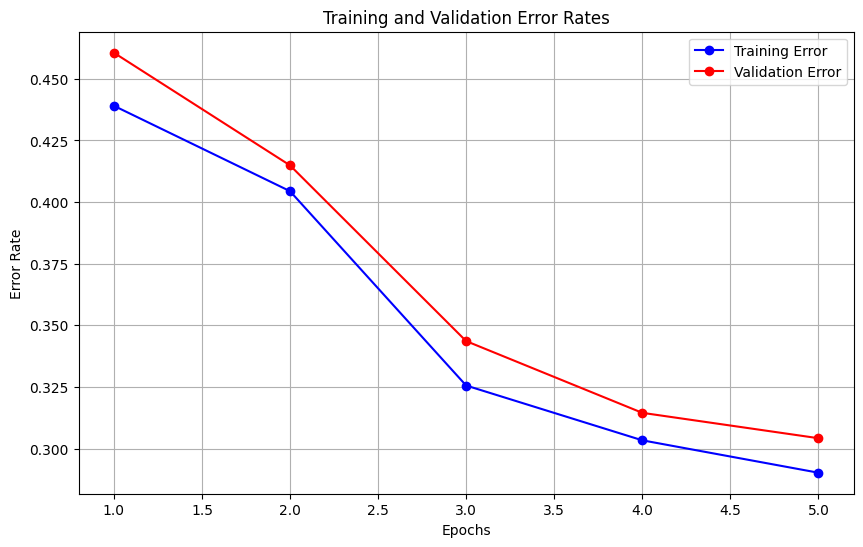

In [24]:
plot_curves(train_error_rates, val_error_rates)